In [1]:
%matplotlib widget

from pathlib import Path

import lotr.plotting as pltltr
import numpy as np
from lotr import A_FISH, FIGURES_LOCATION, LotrExperiment
from lotr.pca import pca_and_phase

COLS = pltltr.COLS
from matplotlib import gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig_location = pltltr.get_nb_figures_location()

In [2]:
exp = LotrExperiment(Path(A_FISH))

pcaed, phase, pca, circle_params = pca_and_phase(exp.traces[:, exp.hdn_indexes])

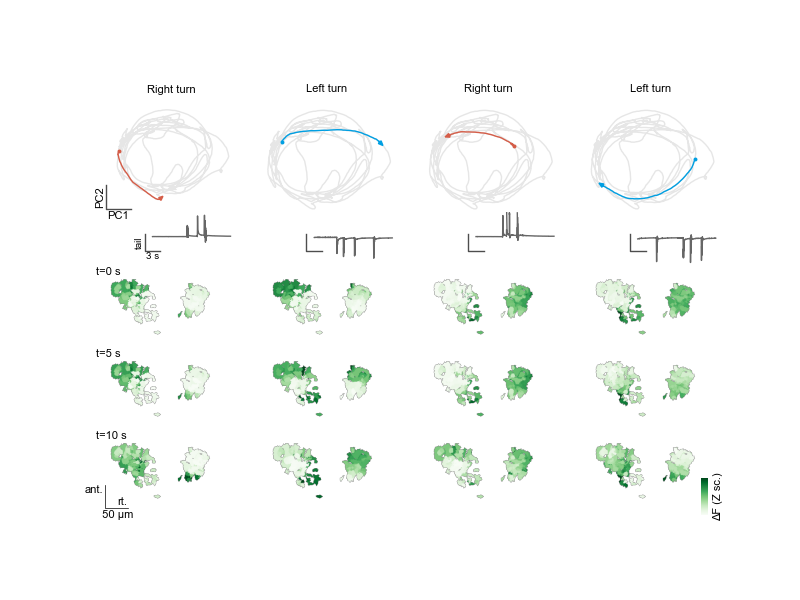

In [3]:
# Indexes around which to crop:
bouts_idxs = dict(rt=[1165, 1010], lf=[3490, 280])

# Number of timepoints shown, and size of each step in imaging samples units:
t_timepts = 3
step = 25

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(5, 4, figure=fig)
pca_axs = [fig.add_subplot(gs[:2, i]) for i in range(4)]
img_axs = [fig.add_subplot(gs[2:, i]) for i in range(4)]
beh_axs = [
    inset_axes(
        ax,
        width="100%",
        height="100%",
        bbox_to_anchor=(0.3, -0.1, 0.7, 0.3),
        bbox_transform=ax.transAxes,
        loc=2,
        borderpad=0,
    )
    for ax in pca_axs
]

y_crop = (80, 260)
pca_t_sl = slice(0, 4000)

for i in range(2):
    for j, side in enumerate(["rt", "lf"]):
        i_col = i * 2 + j
        start_idx = bouts_idxs[side][i]

        pca_ax, beh_ax, img_ax = pca_axs[i_col], beh_axs[i_col], img_axs[i_col]

        # PCA plot
        # --------

        # pca_ax.set_title(dict(rt="Right turn", lf="Left turn")[side], fontsize=8)
        pca_ax.text(
            4, 17, dict(rt="Right turn", lf="Left turn")[side], ha="center", fontsize=8
        )

        # Plot gray:
        pca_ax.plot(pcaed[pca_t_sl, 0], -pcaed[pca_t_sl, 1], lw=1, c=(0.9,) * 3)

        # Plot segment in color:
        pca_seg = pcaed[start_idx : start_idx + step * t_timepts, :].copy()
        pca_seg[:, 1] = -pca_seg[:, 1]  # invert one axis to match anatomy
        pltltr.plot_arrow(pca_seg, ax=pca_ax, col=COLS["sides"][side], s=8)

        pca_ax.axis("equal")

        # Behavior plot:
        # --------------
        seg = (exp.behavior_log.t > (start_idx / exp.fn)) & (
            exp.behavior_log.t < (start_idx + step * t_timepts) / exp.fn
        )

        # Downsample to reduce number of plot points - maybe rasterize in the future
        beh_ax.plot(
            exp.behavior_log[seg].t[::3],
            exp.behavior_log[seg].tail_sum[::3],
            lw=1,
            c=COLS["beh"],
        )

        beh_ax.set(ylim=(-np.pi, np.pi))

        xlabel_bh, ylabel_bh = (None, "tail") if i + j == 0 else ("", "")

        pltltr.add_scalebar(
            ax=beh_ax,
            xlen=3,
            ylen=2,
            ypos=-1.5,
            xlabel=xlabel_bh,
            ylabel=ylabel_bh,
            xunits="s",
            yunits="rad",
            text_params=dict(fontsize=7),
        )

        # ROI maps plot:
        # --------------
        colored = []
        for i_t in range(t_timepts):
            idx = start_idx + i_t * step
            colored_stack = exp.color_rois_by(
                exp.traces[idx, exp.hdn_indexes], color_scheme=COLS["dff_img"]
            )
            colored.append(colored_stack[:, y_crop[0] : y_crop[1], :, :])
        # )
        stacked = np.concatenate(colored[::-1], axis=1)

        im_plot = img_ax.imshow(stacked.max(0), aspect="equal", cmap="Greens")
        y_span = y_crop[1] - y_crop[0]

        if i + j == 0:
            [
                img_ax.text(
                    -10,
                    stacked.shape[1] - i * y_span,
                    f"t={int(i*step/exp.fn)} s",
                    fontsize=8,
                )
                for i in range(t_timepts)
            ]

        [pltltr.despine(ax, "all") for ax in [pca_ax, img_ax, beh_ax]]

        if i_col == 0:
            pltltr.add_scalebar(
                ax=pca_ax,
                xlen=7,
                ylen=7,
                xlabel="PC1",
                ylabel="PC2",
                text_params=dict(fontsize=8),
            )
            pltltr.add_anatomy_scalebar(
                img_ax, text_params=dict(fontsize=8),
            )

        elif i_col == 3:
            cbar = pltltr.add_cbar(
                im_plot, img_ax, (0.9, 0.05, 0.05, 0.15), ticks=[], ticklabels=[]
            )
            cbar.set_label("ΔF (Z sc.)", fontsize=8)


# save if necessary
pltltr.savefig("network_evolution_bouts")